## Exercici
Agafa un conjunt de dades de tema esportiu que t'agradi i selecciona un atribut del conjunt de dades. Calcula el p-valor i digues si rebutja la hipòtesi nul·la agafant un alfa de 5%. 

In [1]:
import os
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#importem de bet365, com en l'exercici anterior, però en aquest cas, agafarem les dades de la lliga espanyola,
#temporada 2018-2019.
pd.options.display.max_columns = None
datasets_path = r"D:\Oscar\FORMACIO\DIGITAL\DATA SCIENCE with Python\Datasets\football stats" + os.sep
file = "2018-2019 La liga.csv"
df = pd.read_csv(datasets_path + file, sep=',', encoding='utf8')
df.sample(3)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,Bb1X2,BbMxH,BbAvH,BbMxD,BbAvD,BbMxA,BbAvA,BbOU,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
333,SP1,24/04/2019,Ath Madrid,Valencia,3,2,H,1,1,D,14,12,6,4,17,13,4,3,3,3,0,0,1.80,3.4,5.0,1.85,3.40,4.6,1.85,3.40,4.55,1.85,3.57,4.87,1.85,3.40,4.6,1.87,3.5,4.75,35,1.95,1.86,3.57,3.43,5.00,4.63,33,2.38,2.25,1.71,1.64,19,-1.00,2.80,2.66,1.55,1.50,1.86,3.45,4.97
308,SP1,07/04/2019,Levante,Huesca,2,2,D,1,0,H,14,17,8,4,22,12,9,1,2,4,0,0,1.95,3.6,3.8,1.95,3.60,3.8,1.97,3.70,3.60,2.02,3.91,3.71,1.95,3.75,3.7,1.95,3.8,3.60,34,2.05,1.98,3.91,3.74,3.80,3.64,33,1.71,1.67,2.30,2.20,19,-0.25,1.76,1.73,2.21,2.16,1.76,4.23,4.44
272,SP1,16/03/2019,Huesca,Alaves,1,3,A,1,1,D,7,12,2,5,21,23,2,2,1,3,0,0,2.45,3.2,3.0,2.50,3.25,2.9,2.50,3.15,3.05,2.52,3.22,3.15,2.45,3.10,3.1,2.50,3.2,3.13,31,2.55,2.47,3.30,3.18,3.15,3.03,33,2.40,2.31,1.66,1.62,19,-0.25,2.16,2.11,1.82,1.78,2.42,3.23,3.31


In [3]:
#utilitzem la mateixa funció que la tasca anterior per extreure les dades dels partits per equip
def df_de_dades_x_team(team, df=df):
    new_cols = ["TEAM", "RIVAL", "GOLS_FAVOR", "GOLS_CONTRA", "RESULTAT", "XUTS", "XUTS_REBUTS", 
                "XUTS_PORTA", "XUTS_PORTA_REBUTS", "CORNERS_LLENÇATS", "CORNERS_REBUTS", 
                "FALTES_COMESES", "FALTES_REBUDES", "TARGETES", "EXPULSIONS"]
    
    #partits de local
    old_cols = ["HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR", "HS", "AS", "HST", "AST", "HC", "AC", "HF", "AF", "HY", "HR"]    
    local_team_df = df[(df.HomeTeam == team)]
    rename = dict(zip(old_cols, new_cols))
    local_team_df = local_team_df.rename(columns=rename)[new_cols]
    #Mapegem la columna de RESULTAT considerant que es local 
    resultat_dic = {"H": "Win", "D": "Draw", "A": "Lose"}
    local_team_df.RESULTAT = local_team_df.RESULTAT.map(resultat_dic)
    
    #partits de visitant
    old_cols = ["AwayTeam", "HomeTeam", "FTAG", "FTHG", "FTR", "AS", "HS", "AST", "HST", "AC", "HC", "AF", "HF", "AY", "AR"]
    away_team_df = df[df.AwayTeam == team]
    rename = dict(zip(old_cols, new_cols))
    away_team_df = away_team_df.rename(columns=rename)[new_cols]
    #Mapegem la columna de RESULTAT considerant que es visitant 
    resultat_dic = {"H": "Lose", "D": "Draw", "A": "Win"}
    away_team_df.RESULTAT = away_team_df.RESULTAT.map(resultat_dic)
    
    #afegim una columna booleana per especificicar si juga de local o visitant
    local_team_df["LOCAL"] = True
    away_team_df["LOCAL"] = False
    
    #finamlment retornem els dos dataframes concatenats
    return local_team_df.append(away_team_df)

In [4]:
#equips
df.HomeTeam.unique()

array(['Betis', 'Girona', 'Barcelona', 'Celta', 'Villarreal', 'Eibar',
       'Real Madrid', 'Vallecano', 'Ath Bilbao', 'Valencia', 'Getafe',
       'Leganes', 'Alaves', 'Ath Madrid', 'Valladolid', 'Espanol',
       'Sevilla', 'Levante', 'Huesca', 'Sociedad'], dtype=object)

In [5]:
#agafem els partits del fc barcelona
barcelona_df = df_de_dades_x_team("Barcelona")
barcelona_df

,TEAM,RIVAL,GOLS_FAVOR,GOLS_CONTRA,RESULTAT,XUTS,XUTS_REBUTS,XUTS_PORTA,XUTS_PORTA_REBUTS,CORNERS_LLENÇATS,CORNERS_REBUTS,FALTES_COMESES,FALTES_REBUDES,TARGETES,EXPULSIONS,LOCAL
2,Barcelona,Alaves,3,0,Win,25,3,9,0,7,1,6,13,0,0,True
26,Barcelona,Huesca,8,2,Win,31,7,15,3,9,4,6,12,1,0,True
45,Barcelona,Girona,2,2,Draw,22,7,11,6,8,2,9,16,3,1,True
60,Barcelona,Ath Bilbao,1,1,Draw,20,8,8,2,4,3,9,18,3,0,True
80,Barcelona,Sevilla,4,2,Win,23,19,9,7,5,7,10,16,0,0,True
97,Barcelona,Real Madrid,5,1,Win,13,15,8,4,4,2,17,14,2,0,True
116,Barcelona,Betis,3,4,Lose,20,15,5,8,10,5,13,11,4,1,True
136,Barcelona,Villarreal,2,0,Win,16,12,7,2,11,1,9,17,2,0,True
164,Barcelona,Celta,2,0,Win,9,11,5,1,4,6,14,15,0,0,True
187,Barcelona,Eibar,3,0,Win,7,15,6,2,2,3,10,12,2,0,True


*Per exemple ens afirmen que la mitjana de xuts per partit d'aquesta temporada del fc barcelona ha baixat respecte a la seva mitjana habitual que ens diuen que és de 15 xuts per partit.*

*Establim la hipòtesi:*

- Ho: μ = 15
- Ha: μ < 15

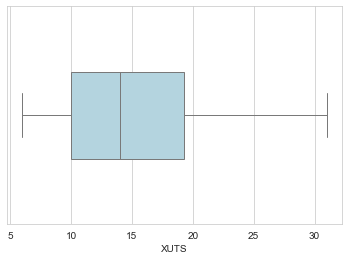

In [6]:
#primerament mirem el tipus de distribució dels xuts
sns.set_style("whitegrid")
ax = sns.boxplot(x="XUTS", data=barcelona_df,  color='lightblue', fliersize=5,  orient='h', linewidth=1 , width=.4)
plt.show()

In [7]:
#segons la prova shapiro és probablement normal
stat, p = stats.shapiro(barcelona_df.XUTS)

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: print('Probablement Normal')
else: print('Probablement No Normal')

stat=0.949, p=0.082
Probablement Normal


In [8]:
#segons la prova normaltest tb és probablement normal
stat, p = stats.normaltest(barcelona_df.XUTS)

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: print('Probablement Normal')
else: print('Probablement No Normal')

stat=3.692, p=0.158
Probablement Normal


In [9]:
#segons la prova anderson tb és probablement normal pel nivell de significança del 5%
result = stats.anderson(barcelona_df.XUTS)

print('stat=%.3f' % (result.statistic))
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print('Probablement Normal al %.1f%%' % (sl))
    else:
        print('Probablement No Normal al %.1f%%' % (sl))

stat=0.603
Probablement No Normal al 15.0%
Probablement No Normal al 10.0%
Probablement Normal al 5.0%
Probablement Normal al 2.5%
Probablement Normal al 1.0%


*Com no tenim suficients indicis per refutar que sigui una distribució normal, asumirem que ho és i realitzarem la prova **t de student** d'una mostra de distribució normal on no coneixem la desviacó standard de la població*

In [10]:
mu = 15.7
data = barcelona_df.XUTS

#calculem valors estadístics de la mostra
n = len(data)
mean = np.mean(data)
dv_st = np.array(data).std(ddof=1) #n-1 graus de llibertat
er_st = dv_st / np.sqrt(n)
print("n = {0}\nmitjana = {1}\ndesviació estàndard = {2}\nerror estàndard = {3}".format(n, mean, dv_st, er_st))

n = 38
mitjana = 14.763157894736842
desviació estàndard = 5.725401959340241
error estàndard = 0.9287828423890262


*per obtindre el valor de t per μ = 15 apliquem la fórmula*
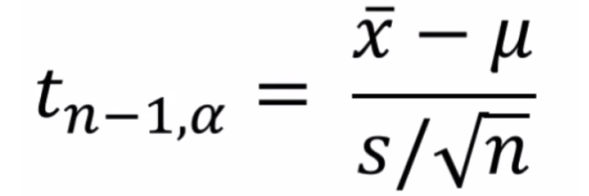

In [11]:
#calculem
t = (mean - mu) / er_st
t

-1.0086772305713578

In [12]:
#amb scipy podem calcular la p que ens dirà el risc que asumim si refutem la hipòtesi nula, o el que es el mateix, 
#la probabilitat o àrea de - infinit a t
stats.t.cdf(t, df=n-1)

0.1598403431967444

*És a dir, com l'estadistic de la hipòtesi nula (16% probabilitats) > alfa (5%) podem concloure que el risc que asumiriem al despreciar la hipòtesi nula és mes gran del que estem disposats a correr.*

**No refutem la hipòtesi nula: No podem afirmar que hagi baixat la seva mitjana de xuts**

*ho podem comprovar tb amb la taula t de student per un nivell de significança del 5% d'una t(n-1=37 graus de libertat)*
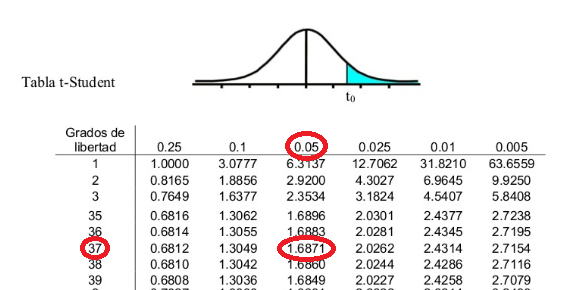

ens dona un valor de 1.6871 (al 5%) per un àrea desde t fins a infinit. Com la gràfica és simètrica entorn al 0, la probabilitat serà la mateixa que desde -t = -1.6871 fins a menys infinit (és un test de cua esquerra)

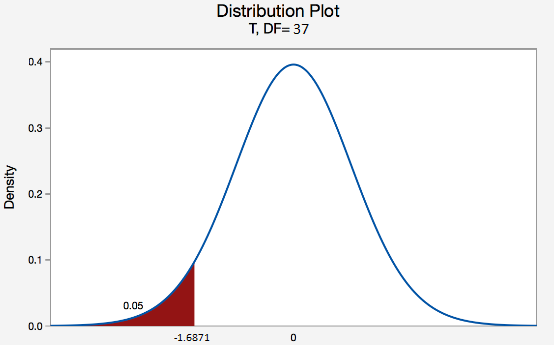

i com t=-1.0087 queda fora de l'area de rebuig, **acceptem la hipòtesi nula**, com ja haviem vist

## Exercici
Continua amb el conjunt de dades de tema esportiu que t'agradi i selecciona dos atributs del conjunt de dades. Calcula el p-valor i digues si rebutja la hipòtesi nul·la agafant un alfa de 5%.

*Per l'excercici plantegem la hipòtesi que quants mes xuts a porta fa un equip, més gols marca.*

*Així doncs la nostre hipòtesi és:*

- Ho: les dos mostres son independents. No hi ha relació entre els xuts a porta i els gols
- Ha: existeix una dependencia entre els xuts a porta i els gols anotats

In [13]:
#farem un nou dataframe amb les dades per equip, creant el nou dataframe per tots els equips i partits, doncs
#volem fer la comparació de xuts a porta vs. gols amb tota la informació que disposem al respecte
teams_data_df = pd.DataFrame()
for team in df.HomeTeam.unique():
    team_data_df = df_de_dades_x_team(team)
    teams_data_df = teams_data_df.append(team_data_df)
teams_data_df.sample(3)

,TEAM,RIVAL,GOLS_FAVOR,GOLS_CONTRA,RESULTAT,XUTS,XUTS_REBUTS,XUTS_PORTA,XUTS_PORTA_REBUTS,CORNERS_LLENÇATS,CORNERS_REBUTS,FALTES_COMESES,FALTES_REBUDES,TARGETES,EXPULSIONS,LOCAL
132,Getafe,Espanol,3,0,Win,14,8,5,2,7,4,17,16,3,0,True
218,Villarreal,Espanol,2,2,Draw,14,17,5,2,3,2,22,16,4,0,True
131,Huesca,Celta,0,2,Lose,8,12,3,5,4,4,14,14,3,0,False


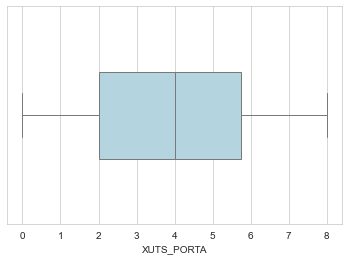

stat=3.692, p=0.158
Probablement de distribució normal


In [14]:
#per elegir el tipus de test (paramètric o no) mirem el tipus de distribució dels xuts a porta
sns.set_style("whitegrid")
ax = sns.boxplot(x="XUTS_PORTA", data=team_data_df,  color='lightblue', fliersize=5,  orient='h', linewidth=1 , width=.4)
plt.show()

#segons la prova normaltest és surt probablement de distribució normal
stat, p = stats.normaltest(barcelona_df.XUTS)

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: print('Probablement de distribució normal')
else: print('Probablement de distribució NO normal')

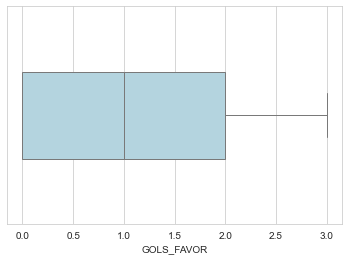

stat=14.664, p=0.001
Probablement No Normal


In [15]:
#mirem el tipus de distribució dels gols a favor
sns.set_style("whitegrid")
ax = sns.boxplot(x="GOLS_FAVOR", data=team_data_df,  color='lightblue', fliersize=5,  orient='h', linewidth=1 , width=.4)
plt.show()

#segons la prova normaltest ens surt que es probablement NO normal
stat, p = stats.normaltest(barcelona_df.GOLS_FAVOR)

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: print('Probablement Normal')
else: print('Probablement No Normal')

*Com ens dona un valor de p del 0.1% < 5% ens veiem amb suficients indicis per refutar que la distribució és normal. Descartarem la hipòtesi nula, i asumirem que te una **distribució No normal**.* 

*Haurem d'aplicar un test d'hipòtesi **no paramètric** per esbrinar si tenen relació entre elles. Utilitzarem el test de Correlació de **rang de Spearman**.*

In [16]:
#Calculem amb Spearman
stat, p = stats.spearmanr(barcelona_df.XUTS, barcelona_df.GOLS_FAVOR)

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: print('Probablement independent')
else: print('Probablement dependent')

stat=0.384, p=0.017
Probablement dependent


*Amb una probabilitat del 1.7% (agafant un nivell de significança alfa del 5%) tenim suficients garanties per descartar la hipòtesi nula i considerar que les variables són **dependents**.*

*Concluïm que **els xuts a porta d'un equip tenen influència en els gols anotats**.*

In [17]:
#podriem fer el mateix amb la prova de correlacio de rang de kendall i ens dona el mateix resultat
stat, p = stats.kendalltau(barcelona_df.XUTS, barcelona_df.GOLS_FAVOR)

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: print('Probablement independent')
else: print('Probablement dependent')

stat=0.296, p=0.018
Probablement dependent


## Exercici
Continua amb el conjunt de dades de tema esportiu que t'agradi i selecciona tres atributs del conjunt de dades. Calcula el p-valor i digues si rebutja la hipòtesi nul·la agafant un alfa de 5%.

*per fer l'excercici, agafarem tres equips amb mitjanes de gols properes i establirem la següent hipotesi:*

- Ho: els tres equips xuten a porta amb la mateixa freqüència.
- Ha: els tres equips NO xuten a porta amb la mateixa freqüència. 

In [18]:
#per fer l'excercici, agafarem tres equips amb mitjanes de gols properes
teams_data_df.groupby("TEAM").GOLS_FAVOR.mean().sort_values()

TEAM
Valladolid     0.842105
Girona         0.973684
Leganes        0.973684
Alaves         1.026316
Vallecano      1.078947
Ath Bilbao     1.078947
Huesca         1.131579
Betis          1.157895
Sociedad       1.184211
Eibar          1.210526
Espanol        1.263158
Getafe         1.263158
Villarreal     1.289474
Valencia       1.342105
Celta          1.394737
Ath Madrid     1.447368
Levante        1.552632
Sevilla        1.631579
Real Madrid    1.657895
Barcelona      2.368421
Name: GOLS_FAVOR, dtype: float64

*agafem Espanyol, Getafe, Villarreal que veiem que son les tres mitjanes que més properes estan entre sí*

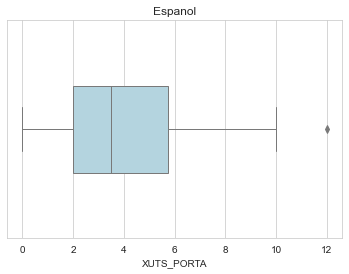

stat=0.912, p=0.006
La distribució dels xuts a porta del Espanol és probablement NO Normal



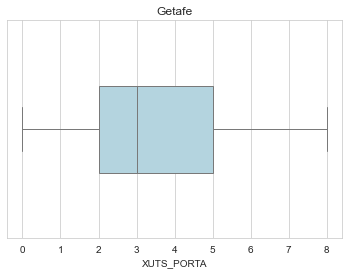

stat=0.929, p=0.018
La distribució dels xuts a porta del Getafe és probablement NO Normal



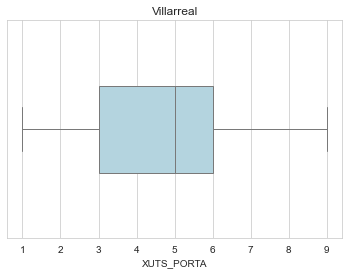

stat=0.970, p=0.403
La distribució dels xuts a porta del Villarreal és probablement Normal



In [19]:
#fem el pronòstic del tipus de distribució que segeixen les variables de xuts a porta per si podem realitzar 
#proves paramètriques (amb millors resultats)
equips = ["Espanol", "Getafe", "Villarreal"]

sns.set_style("whitegrid")

for equip in equips:
    ax = sns.boxplot(x="XUTS_PORTA", data=df_de_dades_x_team(equip), color='lightblue', 
                     fliersize=5,  orient='h', linewidth=1 , width=.4)
    plt.title(equip)
    plt.show()
    
    stat, p = stats.shapiro(df_de_dades_x_team(equip).XUTS_PORTA)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05: print('La distribució dels xuts a porta del {} és probablement Normal\n'.format(equip))
    else: print('La distribució dels xuts a porta del {} és probablement NO Normal\n'.format(equip))

*Veiem que la distribució de dos d'ells, amb el test de normalitat de shapiro, ens retorna una p que ens dona suficients indicis per refutar la seva normalitat.*

*Aleshores haurem d'utilitzar un **test no paramètric** per realitzar la comparació de les tres variables*

*Utilitzarem la prova de **Kruskal-Wallis** per comparar medianes entre dos o més grups de comparació.*

Hipòtesis:

- H0: Las k medianes de les mostres son iguals.
- H1: Las k medianes de les mostres no son totes iguals

In [20]:
Espanol = df_de_dades_x_team("Espanol").XUTS_PORTA
Getafe = df_de_dades_x_team("Getafe").XUTS_PORTA
Villarreal = df_de_dades_x_team("Villarreal").XUTS_PORTA

stat, p = stats.kruskal(Espanol, Getafe, Villarreal)

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: print('Probablement la mateixa mediana')
else: print('Probablement NO tots tenen la mateixa mediana')

stat=7.046, p=0.030
Probablement NO tots tenen la mateixa mediana


*Ens dona un resultat de p del 3% amb el que, com teniem una significança alfa del 5%, tenim suficients indicis per **refutar la hipòtesi nula que tots tres disparen a porta per igual**.*

In [21]:
#podriem mirar les comparacions de dos en dos:
stat, p = stats.kruskal(Espanol, Getafe)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: print('Probablement Espanol i Getafe tenen la mateixa mediana\n')
else: print('Probablement Espanol i Getafe NO tenen la mateixa mediana\n')
    
stat, p = stats.kruskal(Getafe, Villarreal)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: print('Probablement Getafe i Villarreal tenen la mateixa mediana\n')
else: print('Probablement Getafe i Villarreal NO tenen la mateixa mediana\n')
    
stat, p = stats.kruskal(Espanol, Villarreal)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: print('Probablement Espanol i Villarreal tenen la mateixa mediana\n')
else: print('Probablement Espanol i Villarreal NO tenen la mateixa mediana\n')

stat=1.357, p=0.244
Probablement Espanol i Getafe tenen la mateixa mediana

stat=7.759, p=0.005
Probablement Getafe i Villarreal NO tenen la mateixa mediana

stat=1.482, p=0.224
Probablement Espanol i Villarreal tenen la mateixa mediana



*obtenim que és la comparació entre Getafe i Villarreal amb una p del 5% (just al límit del nostre alfa) el que ens dona indicis suficients per refutar la hipòtesi nula que tots tres xuten a porta amb la mateixa freqüència*